# WGAN
数据集：MNIST  

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

In [2]:
# %% 超参数
if sys.platform.startswith('win'):
    datapath = 'D:\\datasets\\mnist_data'
else:
    datapath = '/home/cxmd/文档/data_for_AI_train/mnist_data/'

n_epochs = 200          # 训练次数
batch_size = 64        # 批大小
lr = 0.00005            # 学习率
n_cpu = 8               # cpu数量
latent_dim = 100        # 隐变量维度
img_size = 28           # 图片大小
channels = 1            # 图像通道数
n_critic = 5            # 每次迭代判别器训练的次数
clip_value = 0.01       # 
sample_interval = 400   # 每400次迭代保存一次生成的图片

ngpu = 1            # 使用的GPU数量，使用0表示cpu模式

img_shape = (channels, img_size, img_size)

In [3]:
# 选择我们运行在上面的设备
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [4]:
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/WGAN/run1", exist_ok=True)
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/WGAN/images1", exist_ok=True)

训练集

In [5]:
# transform配置
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5],std=[0.5]),
    ]
)

In [6]:
# 加载mnist数据，同时将数据按照transform的配置预处理
# 判断是什么操作系统，以设置相应的数据集路径

mnist = dset.MNIST(
    root=datapath,
    train=True,
    transform=transform,
    download=True,
)

In [7]:
# 数据集加载器：GAN为无监督机器学习
# 参数dataset是要加载的数据集，这里是预处理后的mnist数据集
# 参数batch_size是每个批次的样本数量
# 参数shuffle为True表示在每个训练周期开始时，对数据进行重新洗牌
data_loader = torch.utils.data.DataLoader(
    dataset = mnist,
    batch_size=batch_size,
    shuffle=True,
)

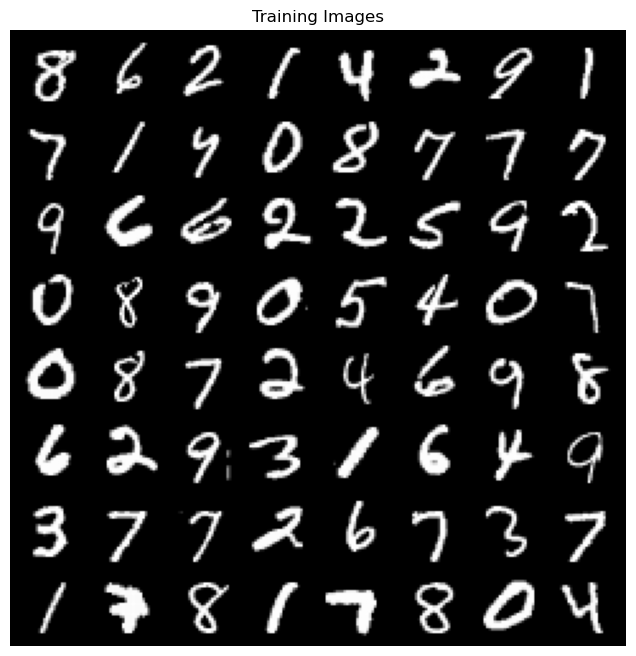

In [8]:
# 绘制部分我们的输入图像
real_batch = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("off")
ax.set_title("Training Images")
ax.imshow(
    vutils.make_grid(
        real_batch[0].to(device)[:64], padding=2, normalize=True
    ).permute(1, 2, 0).cpu()
)
plt.show()

网络

In [9]:
# 生成器
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)                          # 输入形状为(batch_size, latent_dim)
        img = img.view(img.shape[0], *img_shape)     # 输出形状为(batch_size, 1, 28, 28)
        return img


In [10]:
netG = Generator(ngpu).to(device)
print(netG)

# 写入tensorboard
if sys.platform.startswith('win'):
    writerGpath = r'D:\git_files\neural_network\WGAN\run1\Generator'
else:
    writerGpath = r'/home/cxmd/文档/git_files/neural_network/WGAN/run1/Generator'

writerG = SummaryWriter(writerGpath)

input_to_netG = torch.randn(batch_size, latent_dim, device=device)
writerG.add_graph(netG, input_to_model=input_to_netG)
writerG.close()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)


In [11]:
# 判别器
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)      # 输入形状为(batch_size, 28*28)
        validity = self.model(img_flat)            # 输出形状为(batch_size, 1)
        return validity


In [12]:
netD = Discriminator(ngpu).to(device)
print(netD)

if sys.platform.startswith("win"):
    writerDpath = r'D:\git_files\neural_network\WGAN\run1\Discriminator'
else:
    writerDpath = r'/home/cxmd/文档/git_files/neural_network/WGAN/run1/Discriminator'

writerD = SummaryWriter(writerDpath)
input_to_netD = torch.randn(batch_size, int(np.prod(img_shape)), device=device)
writerD.add_graph(netD, input_to_netD)
writerD.close()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [13]:
# Optimizers
optimizer_G = optim.RMSprop(netG.parameters(), lr=lr)
optimizer_D = optim.RMSprop(netD.parameters(), lr=lr)

训练

In [14]:
batches_done = 0
if sys.platform.startswith('win'):
    writerpath = r'D:\git_files\neural_network\WGAN\run1'
else:
    writerpath = r'/home/cxmd/文档/git_files/neural_network/WGAN/run1'
writer = SummaryWriter(writerpath)


for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        
        # 设置输入
        real_imgs = imgs.to(device)
        
        # ------------------
        #  训练 判别器
        # ------------------
        
        optimizer_D.zero_grad()
        
        # 对噪声采样
        z = torch.randn(imgs.shape[0], latent_dim, device=device)
        
        # 生成器产生一批假图片
        fake_imgs = netG(z).to(device).detach()
        
        # 判别器损失
        d_loss = -torch.mean(netD(real_imgs)) + torch.mean(netD(fake_imgs))
        d_loss.backward()
        optimizer_D.step()
        
        
        # 遍历判别器的所有参数
        for p in netD.parameters():
            # 使用clamp_()函数将每个参数的值限制在[-opt.clip_value, opt.clip_value]的范围内
            # 这是Wasserstein GAN（WGAN）的一个关键步骤，称为权重裁剪（Weight Clipping）
            # 这一步是为了满足WGAN的一个重要假设：判别器（或者叫做critic）是一个1-Lipschitz函数
            # Lipschitz条件是WGAN理论保证收敛的关键
            # 注意：clamp_()是一个原地操作（in-place operation），意味着它会直接修改参数的值，而不会返回一个新的张量
            p.data.clamp_(-clip_value, clip_value)
        
        # ------------------
        #  训练 生成器
        # ------------------
        
        if i % n_critic == 0:
            
            optimizer_G.zero_grad()
        
            gen_imgs = netG(z)
            
            # 生成器损失
            g_loss = -torch.mean(netD(gen_imgs))
            
            g_loss.backward()
            optimizer_G.step()
            
            # tensorboard跟踪数据
            writer.add_scalar('loss_d', d_loss.item(), epoch*len(data_loader)+i)
            writer.add_scalar('loss_g', g_loss.item(), epoch*len(data_loader)+i)
            
            
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
            )
            
        if batches_done % sample_interval == 0:
            # writer image to tensorboard
            imgs_to_tensorboard = gen_imgs.data[:25]
            imgs_to_tensorboard = imgs_to_tensorboard.view(5, 5, 28, 28)
            imgs_to_tensorboard = imgs_to_tensorboard.permute(0, 2, 1, 3)
            imgs_to_tensorboard = imgs_to_tensorboard.reshape(1, 5*28, 5*28).cpu()
            writer.add_image("fake_imgs", imgs_to_tensorboard, epoch*len(data_loader)+i)
            save_image(gen_imgs.data[:25], r"/home/cxmd/文档/git_files/neural_network/WGAN/images1/%d.png" % batches_done, nrow=5, normalize=True)

        batches_done += 1
        
writer.close()

[Epoch 0/200] [Batch 0/938] [D loss: 0.034173] [G loss: -0.009966]
[Epoch 0/200] [Batch 5/938] [D loss: -0.106363] [G loss: -0.011024]
[Epoch 0/200] [Batch 10/938] [D loss: -0.353430] [G loss: -0.014502]
[Epoch 0/200] [Batch 15/938] [D loss: -0.761523] [G loss: -0.025539]
[Epoch 0/200] [Batch 20/938] [D loss: -1.263433] [G loss: -0.051203]
[Epoch 0/200] [Batch 25/938] [D loss: -1.869066] [G loss: -0.089191]
[Epoch 0/200] [Batch 30/938] [D loss: -2.431866] [G loss: -0.147987]
[Epoch 0/200] [Batch 35/938] [D loss: -3.033931] [G loss: -0.225889]
[Epoch 0/200] [Batch 40/938] [D loss: -3.727135] [G loss: -0.323683]
[Epoch 0/200] [Batch 45/938] [D loss: -4.306272] [G loss: -0.440168]
[Epoch 0/200] [Batch 50/938] [D loss: -4.954931] [G loss: -0.579808]
[Epoch 0/200] [Batch 55/938] [D loss: -5.427535] [G loss: -0.746925]
[Epoch 0/200] [Batch 60/938] [D loss: -6.188084] [G loss: -0.950525]
[Epoch 0/200] [Batch 65/938] [D loss: -6.655926] [G loss: -1.192651]
[Epoch 0/200] [Batch 70/938] [D loss: